In [ ]:
# Install czmodel and dependencies (only needed once)
#! pip install --upgrade pip
#! pip install czmodel
#!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
# this can be used to switch on/off warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Simple TF2 + Keras model for segmentation (to detect cell nuclei)
This notebook the entire workflow of training an ANN with [TensorFlow 2](https://www.tensorflow.org/) using the keras API and exporting the trained model to the [czmodel format](https://pypi.org/project/czmodel/) to be ready for use within the [Intellesis](https://www.zeiss.com/microscopy/int/products/microscope-software/zen-intellesis-image-segmentation-by-deep-learning.html) infrastructure.

* The trained model is rather simple (for demo purposed) and trained on a small test dataset.
* **Therefore, this notebook is meant to be understood as a guide for exporting trained models**
* **The notebook does not show how train a model correctly.**

In [1]:
# required imports to train a simple TF2 + Keras model for segmentation and package it as CZMODEL
# the CZMODEL can be then imported in ZEN and used for segmentation and image analysis workflows

# general imports
import os
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# those functions are provided by the PyPi package called czmodel (by ZEISS)
from czmodel.util.preprocessing import PerImageStandardization, add_preprocessing_layers
from czmodel.model_metadata import ModelMetadata, ModelSpec
from czmodel import convert_from_model_spec, convert_from_json_spec

In [3]:
# Optional: suppress TF warnings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print(tf.version.GIT_VERSION, tf.__version__)

v2.2.0-rc4-8-g2b96f3662b 2.2.0


## Training Pipeline
This section describes a **simple** training procedure that creates a trained Keras model.

* Therefore, it only represents the custom training procedure
* Such procedure will vary from case to case and will contain more sophisticated ways to generate an optimized Keras model

In [4]:
# Define the parameters for loading the training data

# place the original *.png images here
#IMAGES_FOLDER = 'data2/images/'
IMAGES_FOLDER = 'nucleus_data/images/'

# place the respective label *.png images here
# masks images have one channel (0=background and 1=nucleus)
#MASKS_FOLDER = 'data2/label/'
MASKS_FOLDER = 'nucleus_data/label/'

# define the number of channels
# this means using a grayscale image with one channel only
CHANNELS = 1
NUM_CLASSES = 2

In [6]:
# Read the images
# This part contains the logic to read pairs of images and label masks for training !

# the the sample images
sample_images = sorted([os.path.join(IMAGES_FOLDER, f) for f in os.listdir(IMAGES_FOLDER) 
                        if os.path.isfile(os.path.join(IMAGES_FOLDER, f))])

# get the maks
sample_masks = sorted([os.path.join(MASKS_FOLDER, f) for f in os.listdir(MASKS_FOLDER) 
                       if os.path.isfile(os.path.join(MASKS_FOLDER, f))])

# load images as numpy arrays
images_loaded = np.asarray([tf.image.decode_image(tf.io.read_file(sample_path),
                                                  dtype=tf.dtypes.uint16,
                                                  channels=CHANNELS).numpy() 
                            for sample_path in sample_images]).astype(np.float32)

# normalize the images
images_loaded = (images_loaded - images_loaded.mean()) / images_loaded.mean()


# this i srequired because MobileNet required RGB images
images_loaded = np.tile(images_loaded, (1, 1, 1, 3))

# load labels as numpy arrays
masks_loaded = np.asarray([tf.one_hot(tf.cast(tf.image.decode_image(tf.io.read_file(sample_path),channels=1)[...,0] != 0, tf.dtypes.uint8), depth=NUM_CLASSES).numpy()
for sample_path in sample_masks])

print(images_loaded.shape, masks_loaded.shape)

(29, 1416, 1960, 3) (29, 1416, 1960, 2)


In [7]:
def random_crop_and_pad_image_and_label(image, label, size):
    """Randomly crops image together with labels.

    Args:
      image: A Tensor with shape [D_1, ..., D_K, N]
      label: A Tensor with shape [D_1, ..., D_K, M]
      size: A Tensor with shape [K] indicating the crop size.
    Returns:
      A tuple of (cropped_image, cropped_label).
    """
  
    combined = tf.concat([image, label], axis=2)
    image_shape = tf.shape(image)
    combined_pad = tf.image.pad_to_bounding_box(combined, 0, 0,
                                                tf.maximum(size[0], image_shape[0]),
                                                tf.maximum(size[1], image_shape[1]))
    
    last_label_dim = tf.shape(label)[-1]
    last_image_dim = tf.shape(image)[-1]
    
    combined_crop = tf.image.random_crop(combined_pad,
                                         size=tf.concat([size, [last_label_dim + last_image_dim]],
                                                        axis=0))
    
    return (combined_crop[:, :, :last_image_dim], combined_crop[:, :, last_image_dim:])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(384, 384, 3) (384, 384, 2)
-0.513725 10.35138
0.0 1.0


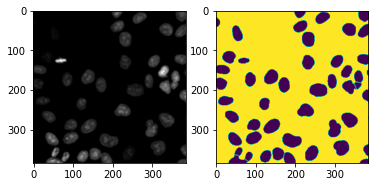

In [8]:
img = images_loaded[28,...]
m = masks_loaded[28,...]

cropped_image, cropped_mask = random_crop_and_pad_image_and_label(image=img,
                                                                  label=m,
                                                                  size=[384, 384])

print(cropped_image.shape, cropped_mask.shape)
print(cropped_image.numpy().min(), cropped_image.numpy().max())
print(cropped_mask.numpy()[:,:,0].min(), cropped_mask.numpy()[:,:,0].max())


fig, (ax1, ax2) = plt.subplots(1, 2)
cropped_image = cropped_image.numpy()
cropped_image_scaled = cropped_image / cropped_image.max()
ax1.imshow(cropped_image_scaled)
ax2.imshow(cropped_mask.numpy()[:,:,0])

In [9]:
tfdataset = tf.data.Dataset.from_tensor_slices((images_loaded, masks_loaded))

# apply the augmentation function to the tfdataset
tfdataset = tfdataset.map(lambda image, label: random_crop_and_pad_image_and_label(image, label, size=[384,384])).batch(1)

In [10]:
sample = next(iter(tfdataset))
#sample

Remark: For details see [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot)

`tf.one_hot creates X channels from X labels: 1 => [0.0, 1.0], 0 => [1.0, 0.0]`

### Define a simple model
This part defines a simple Keras model with two convolutional layers and softmax activation at the output node. It is also possible to add pre.processing layers to the model here.

In order to make the model robust to input scaling we standardize each image before training with the PerImageStandardization layer provided by the `czmodel` package.

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[None, None, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [12]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [13]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[None, None, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3,
                                           strides=2,
                                           activation='softmax',
                                           padding='same')  #64x64 -> 128x128
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
model = unet_model(NUM_CLASSES)

# compile the UNet
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# show model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, None, None,  1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 5 1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, None, 1 0           sequential[0][0]                 
                                                                 model[1][3]                

In [15]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
# Define simple Keras model with two convolutional layers and softmax activation at the output node

#model = tf.keras.models.Sequential([PerImageStandardization(input_shape=(None, None, CHANNELS)),
#                                    tf.keras.layers.Conv2D(16, 3, padding='same'), 
#                                    tf.keras.layers.Conv2D(2, 1, activation='softmax', padding='same')])

#model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, 3, input_shape=(None, None, CHANNELS), padding='same'), 
#                                    tf.keras.layers.Conv2D(2, 1, activation='softmax', padding='same')])

# compile the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#model.summary()

In [ ]:
"""
inputs = tf.keras.layers.Input(shape=(None, None, CHANNELS))
conv1 = tf.keras.layers.Conv2D(16, 3, padding='same')(inputs)
conv2 = tf.keras.layers.Conv2D(16, 3, padding='same', strides=2)(conv1)
conv3 = tf.keras.layers.Conv2DTranspose(16, 3, padding='same', strides=2)(conv2)
conv4 = tf.keras.layers.Conv2D(2, 1, activation='softmax', padding='same')(conv3)
model = tf.keras.models.Model(inputs=inputs, outputs=conv4)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()
"""

### Fit the model to the loaded data
This part fits the model to the loaded data and evaluates it on the training data. In this test example we do not care about an actual evaluation of the model using validation and test data sets.

In [17]:
# define number of training epochs
num_epochs = 200

# fit the model to the data
model.fit(tfdataset,
          batch_size=32,
          epochs=num_epochs)

Epoch 1/200
29/29 [==============================] - 2s 70ms/step - loss: 0.5432 - categorical_accuracy: 0.7892
Epoch 2/200
29/29 [==============================] - 2s 70ms/step - loss: 0.4742 - categorical_accuracy: 0.8180
Epoch 3/200
29/29 [==============================] - 2s 71ms/step - loss: 0.4802 - categorical_accuracy: 0.7987
Epoch 4/200
29/29 [==============================] - 2s 72ms/step - loss: 0.4581 - categorical_accuracy: 0.8239
Epoch 5/200
29/29 [==============================] - 2s 76ms/step - loss: 0.4989 - categorical_accuracy: 0.7877
Epoch 6/200
29/29 [==============================] - 2s 71ms/step - loss: 0.4593 - categorical_accuracy: 0.8199
Epoch 7/200
29/29 [==============================] - 2s 71ms/step - loss: 0.4279 - categorical_accuracy: 0.8327
Epoch 8/200
29/29 [==============================] - 2s 71ms/step - loss: 0.4552 - categorical_accuracy: 0.8153
Epoch 9/200
29/29 [==============================] - 2s 72ms/step - loss: 0.4713 - categorical_accuracy:

29/29 [==============================] - 2s 71ms/step - loss: 0.4622 - categorical_accuracy: 0.8009
Epoch 74/200
29/29 [==============================] - 2s 69ms/step - loss: 0.4776 - categorical_accuracy: 0.8048
Epoch 75/200
29/29 [==============================] - 2s 68ms/step - loss: 0.4373 - categorical_accuracy: 0.8384
Epoch 76/200
29/29 [==============================] - 2s 69ms/step - loss: 0.4531 - categorical_accuracy: 0.8105
Epoch 77/200
29/29 [==============================] - 2s 69ms/step - loss: 0.4632 - categorical_accuracy: 0.7945
Epoch 78/200
29/29 [==============================] - 2s 68ms/step - loss: 0.4662 - categorical_accuracy: 0.8103
Epoch 79/200
29/29 [==============================] - 2s 68ms/step - loss: 0.4349 - categorical_accuracy: 0.8256
Epoch 80/200
29/29 [==============================] - 2s 69ms/step - loss: 0.4578 - categorical_accuracy: 0.8085
Epoch 81/200
29/29 [==============================] - 2s 69ms/step - loss: 0.4551 - categorical_accuracy: 0.8

29/29 [==============================] - 2s 78ms/step - loss: 0.4456 - categorical_accuracy: 0.8248
Epoch 146/200
29/29 [==============================] - 2s 75ms/step - loss: 0.4647 - categorical_accuracy: 0.7897
Epoch 147/200
29/29 [==============================] - 2s 75ms/step - loss: 0.4692 - categorical_accuracy: 0.8041
Epoch 148/200
29/29 [==============================] - 2s 76ms/step - loss: 0.4588 - categorical_accuracy: 0.8170
Epoch 149/200
29/29 [==============================] - 2s 74ms/step - loss: 0.3929 - categorical_accuracy: 0.8567
Epoch 150/200
29/29 [==============================] - 2s 76ms/step - loss: 0.4607 - categorical_accuracy: 0.8091
Epoch 151/200
29/29 [==============================] - 2s 80ms/step - loss: 0.4630 - categorical_accuracy: 0.8124
Epoch 152/200
29/29 [==============================] - 2s 75ms/step - loss: 0.4553 - categorical_accuracy: 0.8069
Epoch 153/200
29/29 [==============================] - 2s 76ms/step - loss: 0.4650 - categorical_accur

In [18]:
# get the loss and acuary values
#loss, accuracy = model.evaluate(images_loaded, masks_loaded)
loss, accuracy = model.evaluate(tfdataset)

# show the final accuracy achieved
print("The model achieves {}% accuracy on the training data.".format(accuracy * 100))

29/29 [==============================] - 2s 72ms/step - loss: 0.4102 - categorical_accuracy: 0.8457
The model achieves 84.56722497940063% accuracy on the training data.


In [19]:
dataset_it = iter(tfdataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(384, 384, 3) (384, 384)
-0.513725 5.704745
0 1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


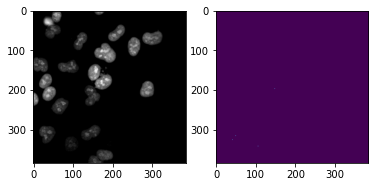

In [32]:
sample = next(dataset_it)[0]
pred = model.predict(sample)[0]
pred = np.argmax(pred, axis=-1)

sample = sample.numpy()[0]
sample_scaled = sample / sample.max()

print(sample.shape, pred.shape)
print(sample.min(), sample.max())
print(pred.min(), pred.max())
print(pred)

#pred = np.tile(pred[:,:,1:], (1,1,3))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(sample_scaled)
ax2.imshow(pred) 

## Create a CZModel from the trained Keras model

In this section we export the trained model to the CZModel format using the czmodel library and some additional meta data all possible parameter choices are described in the [ANN model specification](https://pypi.org/project/czmodel/) that can be found on the PyPi packager for `czmodel`.

### Define Meta-Data

We first define the meta-data needed to run the model within the Intellesis infrastructure. The `czmodel` package offers a named tuple `ModelMetadata` that allows to either parse as JSON file as described or to directly specify the parameters as shown below.

### Create a Model Specification Object

The export functions provided by the `czmodel` package expect a `ModelSpec` tuple that features the Keras model to be exported and the corresponding model metadata.

Therefore, we wrap our model and the `model_metadata` instance into a `ModelSpec` object.

In [ ]:
# Define the model metadata
model_metadata = ModelMetadata.from_params(name='Simple_Nuclei_SegmentationModel', 
                                           color_handling='ConvertToMonochrome',
                                           pixel_type='Gray16',
                                           classes=["Background", "Nucleus"],
                                           border_size=8)


# Create a model specification object used for conversion
model_spec = ModelSpec(model=model, model_metadata=model_metadata)

### Perform model export into *.czmodel file format

The `czmodel` library offers two functions to perform the actual export. 

* `convert_from_json_spec` allows to provide a JSON file with all information to convert a model in SavedModel format on disk to a `.czmodel` file that can be loaded with ZEN.
* `convert_from_model_spec` expects a `ModelSpec` object, an output path and name and optionally target spatial dimensions for the expected input of the exported model. From this information it creates a `.czmodel` file containing the specified model.

```python
convert_from_model_spec(model_spec=model_spec, 
                        output_path=folder_to_store_czmodel, 
                        output_name=name_of_the_model, 
                        spatial_dims=spatial_dims)
```

In [ ]:
# Define dimensions - ZEN Intellesis requires fully defined spatial dimensions.
# This is the tile size used by the ZEN TilingClient to pass a. image to the segmentation service.

# Important: The tile size has to be chosen s.t. inference is possible with the minimum hardware requirements of Intellesis
spatial_dims = 1024, 1024  # Optional: Define target spatial dimensions of the model for inference.

convert_from_model_spec(model_spec=model_spec, 
                        output_path='./czmodel_output', 
                        output_name='simple_nuclei_segmodel', 
                        spatial_dims=spatial_dims)

# In the example above there will be a ""./czmodel_output/simple_nuclei_segmodel.czmodel" file saved on disk.

## Remarks
The generated .czmodel file can be directly loaded into ZEN Intellesis to perform segmentation tasks with the trained model.
If there is already a trained model in SavedModel format present on disk, it can also be converted by providing a meta-data JSON file as described in the [ANN Model Specification](https://pypi.org/project/czmodel/).

The following JSON document describes the same meta-data applied in the use case above:

```json
{
"BorderSize": 8,
"ColorHandling": "ConvertToMonochrome",
"PixelType": "Gray16",
"Classes": ["Background", "Nuclei"],
"ModelPath": "saved_tf2_model_output",
}
```

This information can be copied to a file e.g. in the current working directory `./model_spec.json` that also contains the trained model in SavedModel format e.g. generated by the following line:

In [ ]:
# save the trained TF2.SavedModel as a folder structure
# The folder + the JSON file can be also used to import the model in ZEN

model.save('./saved_tf2_model_output_dims_unset/')
add_preprocessing_layers(model, layers=None, spatial_dims=spatial_dims).save('./saved_tf2_model_output/')

The CZMODEL file (which is essentially a zip file) contains:

* **model guid file**: modelid=e47aabbd-8269-439c-b142-78feec2ed2dd


* **model file**: modelid=e47aabbd-8269-439c-b142-78feec2ed2dd.model


* **model description**: e47aabbd-8269-439c-b142-78feec2ed2dd.xml

**Example of a model XML description**

<img src="./mdpics/model_xml.png" >

To import the newly created model just use the **`Import`** function of the Intellesis Trainable Segmentation module in ZEN.

<img src="./mdpics/zen_import_model1.png" >

Select the **`simple_nuclei_segmodel.czmodel`** file and press the **`Open`** button.

<img src="./mdpics/zen_import_model2.png" >

Use the IP-function **`Segmentation`** to segment an image using the imported CZMODEL (containing the trained network).

<img src="./mdpics/zen_import_model_IPseg.png">

To use the trained model to analyse an image there are two main options

1. directly create an Image Analysis Setting based on the model (no class hierarchy, but very simple)
2. assign the trained model to s specific class inside a customized image analysis setting (shown below)

The crucial step (when not using option 1) is the Select the correct **`Class Segmentation Method`** inside the Image Analysis Wizard.

<img src="./mdpics/zen_import_model_IA1.png">

Use the **`Select Model`** function to assign the trained model and the actual **class** (from the trained model) of interest to assign the model / class to the respective object inside the image analysis setting.

<img src="./mdpics/zen_import_model_IA2.png" >

Now the trained model will be used to segment the image. The built-in ZEN Tiling Client automatically  to chunk the image and deal with complex dimensions, like Use the **`Scenes`** etc.

Additional Post-Processing options, incl. a Minimum Confidence Threshold can be applied to further refine the results.

<img src="./mdpics/zen_import_model_IA3.png" >

Finally, the model can be loaded into ZEN by using the **Import** function on the **JSON file**. 

If the model is supposed to be provided to other parties it is usually easier to exchange .czmodel files instead of SavedModel directories with corresponding JSON meta-data files.

The `czmodel` library also provides a `convert_from_json_spec` function that accepts the above mentioned JSON file and creates a CZModel:

In [ ]:
# This is an additional way how to create a CZMODEL from a saved TF2 model on disk + JSON file.
# The currently recommended way to to create the CZMODEL directly by using czmodel.convert_from_model_spec
# the path to the TF2.SavedModel folder is defined in the JSON shown above

convert_from_json_spec(model_spec_path='model_spec_dims_unset.json',
                       output_path='model_from_json',
                       output_name = 'simple_nuclei_segmodel_from_json',
                       spatial_dims=spatial_dims)

* the path to the saved model folder is defined in the JSON shown above

* **Remark: Due a TF 2.1 bug reloading a model does currently not work correctly.** See issue: https://github.com/tensorflow/tensorflow/issues/37158. This works with TF 2.0 and will be fixed again with TF 2.2. We currently do not have any information if there will be released a patch for TF 2.1 that fixes the issue there.

Use the commands below from a terminal to present the notebook as a slideshow.

`
jupyter nbconvert train_simple_TF2_segmentation_model.ipynb --to slides --post serve 
    --SlidesExporter.reveal_theme=serif 
    --SlidesExporter.reveal_scroll=True 
    --SlidesExporter.reveal_transition=none
`

Or install the [RISE Extension](https://rise.readthedocs.io/en/stable/) to display a a slideshow directly from within the notebook